In [1]:
#!/usr/bin/env python
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%reload_ext autoreload
%autoreload 2
import smplotlib
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# basis test

In [3]:
import glob

atm_files = glob.glob('data/Sync_Spectra_All_Atm/*.atm')

In [8]:
# Get the first file path
first_file = atm_files[0]
print(f"Reading file: {first_file}")

# Read the content of the first file
with open(first_file, 'r') as f:
    content = f.read()
    
# Display the first few lines to see the structure
print("First 10 lines of the file:")
print("\n".join(content.split('\n')[:100]))

Reading file: data/Sync_Spectra_All_Atm/at12hajgci_t04140g1.41.atm
First 10 lines of the file:
TEFF   4140.  GRAVITY  1.4100 LTE 
TITLE ATLAS12 l/H=1.25                                                          
 OPACITY IFOP 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0
 CONVECTION ON   1.25 TURBULENCE OFF  0.00  0.00  0.00  0.00
ABUNDANCE SCALE   1.00000 ABUNDANCE CHANGE 1 0.92119 2 0.07837
 ABUNDANCE CHANGE  3 -11.40  4 -11.07  5  -9.76  6  -3.99  7  -4.48  8  -3.65
 ABUNDANCE CHANGE  9  -7.89 10  -4.53 11  -6.32 12  -4.73 13  -5.96 14  -4.87
 ABUNDANCE CHANGE 15  -6.91 16  -5.21 17  -6.96 18  -6.05 19  -7.36 20  -6.07
 ABUNDANCE CHANGE 21  -9.30 22  -7.33 23  -8.51 24  -6.82 25  -7.03 26  -4.96
 ABUNDANCE CHANGE 27  -7.41 28  -6.22 29  -8.09 30  -7.89 31  -9.41 32  -8.80
 ABUNDANCE CHANGE 33 -10.15 34  -9.12 35  -9.91 36  -9.21 37  -9.94 38  -9.59
 ABUNDANCE CHANGE 39 -10.24 40  -9.88 41 -10.99 42 -10.57 43 -20.41 44 -10.71
 ABUNDANCE CHANGE 45 -11.54 46 -10.88 47 -11.52 48 -10.74 49 -11.

In [2]:
!ls data/

C3K_atmosphere
C3K_atmosphere.tar.gz
Sync_Spectra_All_Atm
Sync_Spectra_All_Atm_1e6_Full_Atlas12_Synthe.tar.gz
apogee_training_labels_1e6_synthe_only.npz
kurucz_dataset.pt
kurucz_vturb_0p5_tau.pt
kurucz_vturb_0p5_tau_v2.pt
kurucz_vturb_0p5_tau_v3.pt


In [4]:
data = np.load("data/apogee_training_labels_1e6_synthe_only.npz")

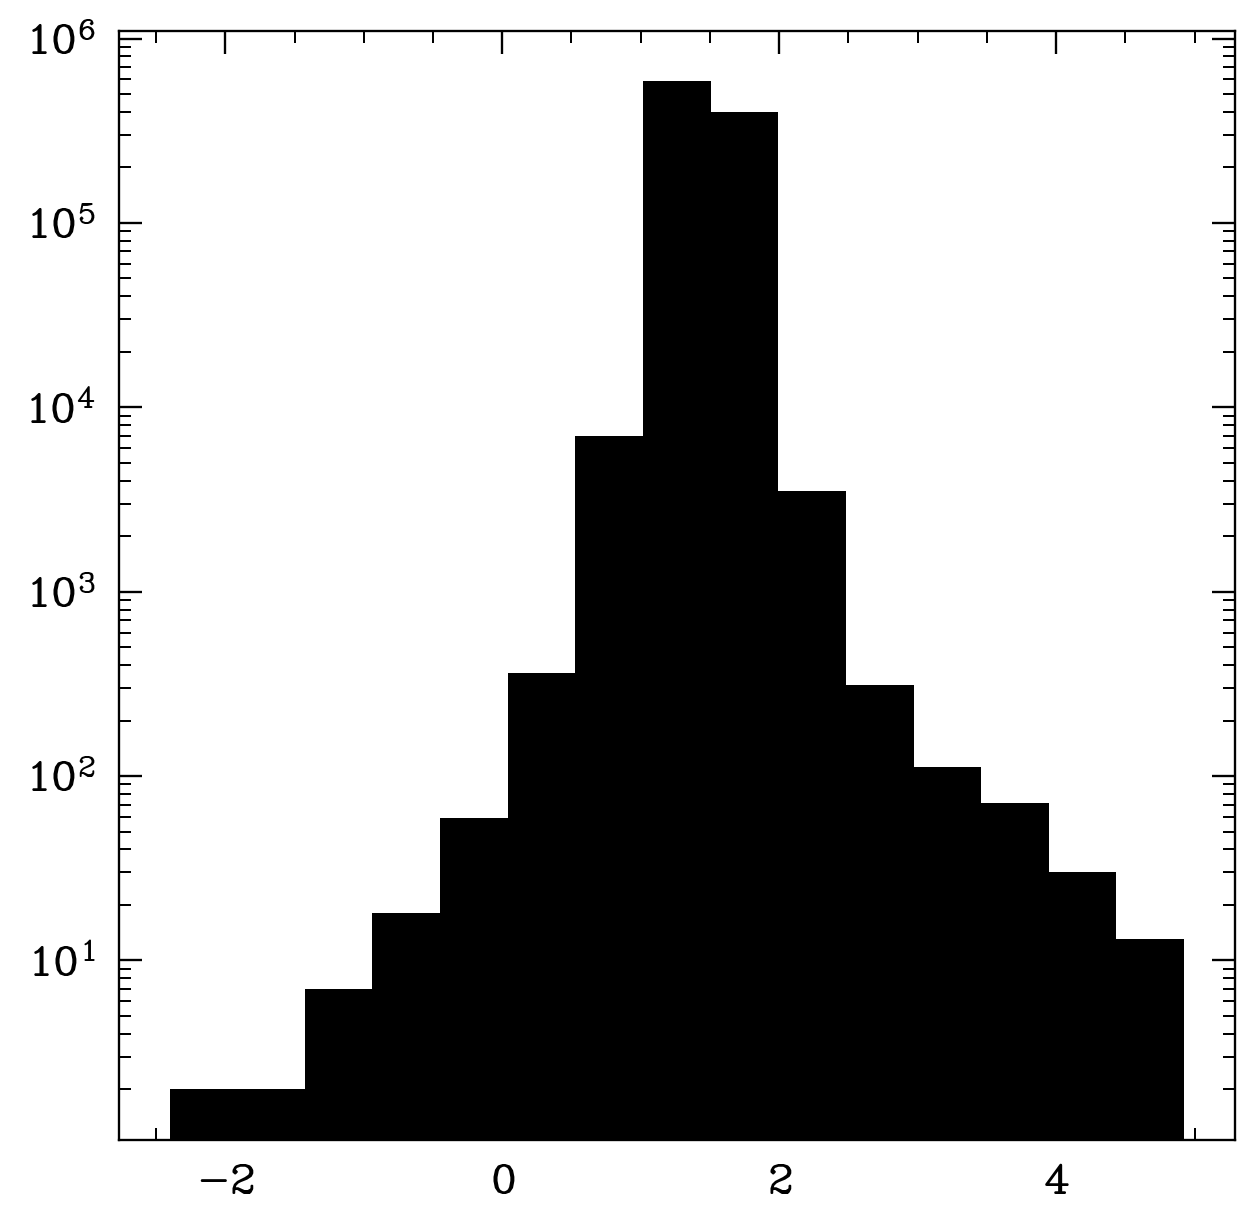

In [5]:
plt.hist(data['labels'].T[2], log=True);

In [18]:
def extract_atm_parameters(file_path):
    # Initialize variables
    teff = None
    logg = None
    feh = None
    afe = 0.0
    vturb = None
    layers = []
    
    # Alpha elements and their solar abundances (log(N_X/N_H), Asplund et al., 2009)
    alpha_elements = {
        8: -3.31,  # O
        12: -4.51, # Mg
        14: -4.49, # Si
        20: -5.68, # Ca
        22: -7.05  # Ti
    }
    alpha_abundances = {}
    fe_abundance = None
    solar_fe = -4.50  # Solar Fe abundance
    
    with open(file_path, 'r') as f:
        lines = f.readlines()
        in_layer_table = False
        
        for i, line in enumerate(lines):
            # Extract TEFF and log g
            if line.startswith("TEFF"):
                parts = line.split()
                teff = float(parts[1])
                logg = float(parts[3])
            
            # Extract vturb
            if "TURBULENCE" in line:
                parts = line.split()
                if "OFF" in line:
                    vturb = 0.0
                elif "ON" in line:
                    vturb = float(parts[3])
            
            # Extract abundance changes
            if "ABUNDANCE CHANGE" in line:
                parts = line.split()
                j = 2  # Start from the third element (index 2)
                while j < len(parts):
                    try:
                        elem = int(parts[j])
                        if j + 1 < len(parts):
                            abund = float(parts[j + 1])
                            if elem == 26:  # Iron
                                fe_abundance = abund
                            elif elem in alpha_elements:
                                alpha_abundances[elem] = abund
                        j += 2
                    except ValueError:
                        # If we can't convert to int, skip this part
                        j += 1
            
            # Detect and parse layer table
            if "RHOX" in line and "T" in line and "P" in line:
                in_layer_table = True
                continue
            
            if in_layer_table and line.strip() and not line.startswith(" " * 10):
                try:
                    parts = line.split()
                    if len(parts) >= 6:
                        layer = {
                            "RHOX": float(parts[0]),
                            "T": float(parts[1]),
                            "P": float(parts[2]),
                            "XNE": float(parts[3]),
                            "ABROSS": float(parts[4]),
                            "ACCRAD": float(parts[5])
                        }
                        layers.append(layer)
                except (ValueError, IndexError):
                    in_layer_table = False
        
        # Calculate [Fe/H]
        if fe_abundance is not None:
            feh = fe_abundance - solar_fe
        
        # Calculate [α/Fe]
        if fe_abundance is not None and alpha_abundances:
            alpha_h = []
            for elem, abund in alpha_abundances.items():
                solar_alpha = alpha_elements[elem]
                alpha_h.append(abund - solar_alpha)  # [α/H] for each element
            avg_alpha_h = sum(alpha_h) / len(alpha_h)
            feh = fe_abundance - solar_fe
            afe = avg_alpha_h - feh
    
    return teff, logg, feh, afe, vturb, layers
# Print results
print(f"TEFF: {teff} K")
print(f"log g: {logg}")
print(f"[Fe/H]: {feh if feh is not None else 'Not found'}")
print(f"[α/Fe]: {afe}")
print(f"vturb: {vturb} km/s" if vturb is not None else "vturb: Not found")

# Print layer data
if layers:
    print("\nAtmospheric Layers:")
    print("RHOX (g/cm²)  T (K)    P (dyn/cm²)  XNE (cm⁻³)  ABROSS (cm²/g)  ACCRAD (cm/s²)")
    for layer in layers:
        print(f"{layer['RHOX']:>10.6f}  {layer['T']:>7.1f}  {layer['P']:>11.3e}  "
              f"{layer['XNE']:>11.3e}  {layer['ABROSS']:>11.3e}  {layer['ACCRAD']:>11.3e}")
else:
    print("\nNo layer data found in the file.")
# Example usage
teff, logg, feh, afe, vturb, layers = extract_atm_parameters(first_file)

# Print header parameters
print(f"TEFF: {teff} K")
print(f"log g: {logg}")
print(f"[Fe/H]: {feh if feh is not None else 'Not found'}")
print(f"[α/Fe]: {afe}")
print(f"vturb: {vturb} km/s" if vturb is not None else "vturb: Not found")

# Print layer data
if layers:
    print("\nAtmospheric Layers:")
    print("RHOX (g/cm²)  T (K)    P (dyn/cm²)  XNE (cm⁻³)  ABROSS (cm²/g)  ACCRAD (cm/s²)")
    for layer in layers:
        print(f"{layer['RHOX']:>10.6f}  {layer['T']:>7.1f}  {layer['P']:>11.3e}  "
              f"{layer['XNE']:>11.3e}  {layer['ABROSS']:>11.3e}  {layer['ACCRAD']:>11.3e}")
else:
    print("\nNo layer data found in the file.")

    

TEFF: 4140.0 K
log g: 1.41
[Fe/H]: -0.45999999999999996
[α/Fe]: 0.13799999999999973
vturb: 0.0 km/s

Atmospheric Layers:
RHOX (g/cm²)  T (K)    P (dyn/cm²)  XNE (cm⁻³)  ABROSS (cm²/g)  ACCRAD (cm/s²)
  0.012535   2341.3    3.222e-01    2.624e+06    1.064e-05    2.656e-03
  0.016625   2366.7    4.273e-01    3.514e+06    1.111e-05    2.431e-03
  0.021842   2391.6    5.614e-01    4.663e+06    1.163e-05    2.219e-03
  0.028491   2416.7    7.323e-01    6.155e+06    1.216e-05    2.018e-03
  0.036961   2442.2    9.499e-01    8.096e+06    1.273e-05    1.836e-03
  0.047738   2467.8    1.227e+00    1.062e+07    1.335e-05    1.672e-03
  0.061417   2493.6    1.579e+00    1.389e+07    1.405e-05    1.530e-03
  0.078718   2519.6    2.023e+00    1.812e+07    1.484e-05    1.404e-03
  0.100524   2545.7    2.584e+00    2.359e+07    1.573e-05    1.295e-03
  0.127901   2572.0    3.287e+00    3.064e+07    1.674e-05    1.199e-03
  0.162126   2598.4    4.167e+00    3.969e+07    1.790e-05    1.116e-03
  0.2047

In [20]:
file_name = "/Users/jdli/Project/kurucz1/data/C3K_atmosphere/atm_vturb=0.5/at12_feh-0.50_afe+0.2_t04000g-0.5.atm"

teff, logg, feh, afe, vturb, layers = extract_atm_parameters(file_name)

# Print header parameters
print(f"TEFF: {teff} K")
print(f"log g: {logg}")
print(f"[Fe/H]: {feh if feh is not None else 'Not found'}")
print(f"[α/Fe]: {afe}")
print(f"vturb: {vturb} km/s" if vturb is not None else "vturb: Not found")

# Print layer data
if layers:
    print("\nAtmospheric Layers:")
    print("RHOX (g/cm²)  T (K)    P (dyn/cm²)  XNE (cm⁻³)  ABROSS (cm²/g)  ACCRAD (cm/s²)")
    for layer in layers:
        print(f"{layer['RHOX']:>10.6f}  {layer['T']:>7.1f}  {layer['P']:>11.3e}  "
              f"{layer['XNE']:>11.3e}  {layer['ABROSS']:>11.3e}  {layer['ACCRAD']:>11.3e}")
else:
    print("\nNo layer data found in the file.")

TEFF: 4000.0 K
log g: -0.5
[Fe/H]: -0.54
[α/Fe]: 0.22599999999999998
vturb: 0.0 km/s

Atmospheric Layers:
RHOX (g/cm²)  T (K)    P (dyn/cm²)  XNE (cm⁻³)  ABROSS (cm²/g)  ACCRAD (cm/s²)
  0.023085   2123.2    7.268e-03    6.234e+04    5.777e-06    1.382e-03
  0.030678   2144.6    9.659e-03    8.336e+04    5.938e-06    1.230e-03
  0.040525   2165.6    1.276e-02    1.108e+05    6.108e-06    1.096e-03
  0.053291   2186.8    1.679e-02    1.469e+05    6.283e-06    9.756e-04
  0.069828   2208.2    2.200e-02    1.944e+05    6.466e-06    8.681e-04
  0.091249   2229.9    2.876e-02    2.567e+05    6.659e-06    7.745e-04
  0.118978   2251.7    3.750e-02    3.388e+05    6.862e-06    6.929e-04
  0.154845   2273.8    4.882e-02    4.468e+05    7.077e-06    6.224e-04
  0.201202   2296.1    6.346e-02    5.891e+05    7.305e-06    5.606e-04
  0.261062   2318.7    8.235e-02    7.766e+05    7.547e-06    5.070e-04
  0.338278   2341.7    1.067e-01    1.024e+06    7.807e-06    4.599e-04
  0.437762   2365.0    

In [22]:
file_name = "/Users/jdli/Project/kurucz1/data/C3K_atmosphere/atm_vturb=0.5/at12_feh-1.00_afe+0.0_t05250g2.00.atm"

teff, logg, feh, afe, vturb, layers = extract_atm_parameters(file_name)

# Print header parameters
print(f"TEFF: {teff} K")
print(f"log g: {logg}")
print(f"[Fe/H]: {feh if feh is not None else 'Not found'}")
print(f"[α/Fe]: {afe}")
print(f"vturb: {vturb} km/s" if vturb is not None else "vturb: Not found")

# Print layer data
if layers:
    print("\nAtmospheric Layers:")
    print("RHOX (g/cm²)  T (K)    P (dyn/cm²)  XNE (cm⁻³)  ABROSS (cm²/g)  ACCRAD (cm/s²)")
    for layer in layers:
        print(f"{layer['RHOX']:>10.6f}  {layer['T']:>7.1f}  {layer['P']:>11.3e}  "
              f"{layer['XNE']:>11.3e}  {layer['ABROSS']:>11.3e}  {layer['ACCRAD']:>11.3e}")
else:
    print("\nNo layer data found in the file.")

TEFF: 5250.0 K
log g: 2.0
[Fe/H]: -1.04
[α/Fe]: 0.0259999999999998
vturb: 0.0 km/s

Atmospheric Layers:
RHOX (g/cm²)  T (K)    P (dyn/cm²)  XNE (cm⁻³)  ABROSS (cm²/g)  ACCRAD (cm/s²)
  0.007073   3388.6    7.073e-01    1.545e+07    1.885e-05    1.758e-03
  0.009392   3411.0    9.393e-01    2.037e+07    1.949e-05    1.774e-03
  0.012383   3425.3    1.238e+00    2.665e+07    2.017e-05    1.817e-03
  0.016226   3444.0    1.623e+00    3.467e+07    2.099e-05    1.847e-03
  0.021139   3464.4    2.114e+00    4.484e+07    2.194e-05    1.861e-03
  0.027390   3486.3    2.739e+00    5.770e+07    2.305e-05    1.863e-03
  0.035302   3509.4    3.530e+00    7.388e+07    2.434e-05    1.858e-03
  0.045262   3533.5    4.526e+00    9.411e+07    2.586e-05    1.845e-03
  0.057729   3558.2    5.773e+00    1.193e+08    2.763e-05    1.828e-03
  0.073242   3583.4    7.324e+00    1.505e+08    2.969e-05    1.811e-03
  0.092431   3609.0    9.243e+00    1.889e+08    3.210e-05    1.792e-03
  0.116030   3635.0    1.

In [23]:
from dataset import read_kurucz_model

In [36]:
f1 = read_kurucz_model("/Users/jdli/Project/kurucz1/data/C3K_atmosphere/atm_vturb=0.5/at12_feh-1.00_afe+0.0_t05250g2.00.atm")
f2 = read_kurucz_model("/Users/jdli/Project/kurucz1/data/C3K_atmosphere/atm_vturb=3.0/at12_feh-1.00_afe+0.0_t05250g2.00.atm")

In [37]:
f1.keys()

dict_keys(['teff', 'gravity', 'title', 'feh', 'afe', 'filename', 'opacity_ifop', 'convection', 'turbulence', 'abundance_scale', 'abundance_changes', 'RHOX', 'T', 'P', 'XNE', 'ABROSS', 'ACCRAD', 'VTURB', 'data_columns', 'extra_columns'])

1672.0 5547.763001104134
1672.0 5547.763001104134


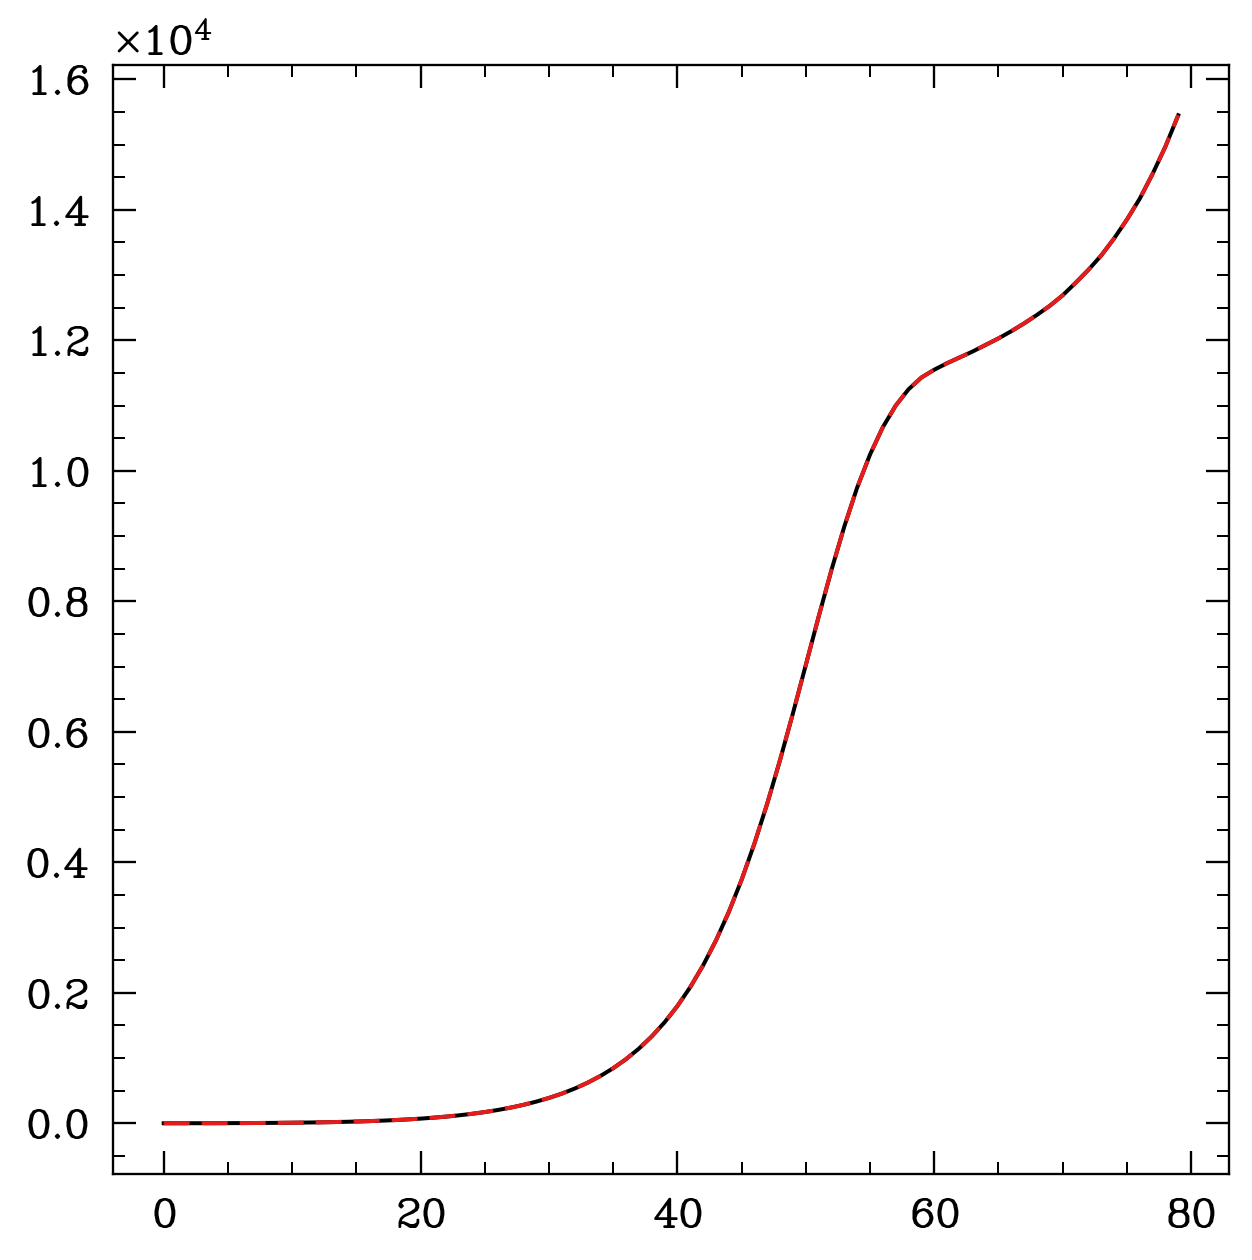

In [39]:
key_name = "P"
plt.plot(f1[key_name])
plt.plot(f2[key_name], ls='--')

# print(np.median(f1[key_name]-f2[key_name]), np.std(f1[key_name]-f2[key_name]))
print(np.median(f1[key_name]), np.std(f1[key_name]))
print(np.median(f2[key_name]), np.std(f2[key_name]))
plt.show()

# make v3 pt files

In [25]:
from dataset import KuruczDataset
import numpy as np
import torch
from torch.utils.data import DataLoader

In [40]:
k_data = KuruczDataset(data_dir=["/Users/jdli/Project/kurucz1/data/C3K_atmosphere/atm_vturb=0.5/", 
                                 "/Users/jdli/Project/kurucz1/data/Sync_Spectra_All_Atm",])

Error loading /Users/jdli/Project/kurucz1/data/C3K_atmosphere/atm_vturb=0.5/at12_feh-1.00_afe+0.6_t05000g0.00.atm: could not convert string to float: '1.362E+14-3.951E+00'


In [42]:
len(k_data)

1042696

In [43]:
from dataset import save_dataset

save_dataset(k_data, "data/kurucz_v4.pt")

Dataset saved to data/kurucz_v4.pt


# make v5 pt files: T is also be logarithm

In [2]:
from dataset import read_kurucz_model, save_dataset
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset import KuruczDataset


k_data = KuruczDataset(data_dir=["/Users/jdli/Project/kurucz1/data/C3K_atmosphere/atm_vturb=0.5/", 
                                 "/Users/jdli/Project/kurucz1/data/Sync_Spectra_All_Atm/",])


save_dataset(k_data, "data/kurucz_v5.pt")

Error loading /Users/jdli/Project/kurucz1/data/C3K_atmosphere/atm_vturb=0.5/at12_feh-1.00_afe+0.6_t05000g0.00.atm: could not convert string to float: '1.362E+14-3.951E+00'
Dataset saved to data/kurucz_v5.pt
